# 1. Importing Libraries and Datasets

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from IPython.display import display, HTML
from IPython.display import Image

import seaborn as sns
from scipy import stats

import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

warnings.filterwarnings("ignore")

In [2]:
cab_data = pd.read_csv('Cab_Data.csv')
customer_data = pd.read_csv('Customer_ID.csv')
transaction_data = pd.read_csv('Transaction_ID.csv')
city_data = pd.read_csv('City.csv')

# 2. Exploratory Data Analysis (EDA)

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(f"Rows: {dataframe.shape[0]}")
    print(f"Columns: {dataframe.shape[1]}")

    print("\n##################### Types #####################")
    print(dataframe.dtypes)

    print("\n##################### Head #####################")
    print(dataframe.head(head))

    print("\n##################### Tail #####################")
    print(dataframe.tail(head))

    print("\n##################### NA #####################")
    print(dataframe.isnull().sum())

    print("\n##################### Quantiles #####################")
    print(dataframe.describe().T)

In [4]:
# Checking for duplicates

def check_duplicates(dataframe):
    duplicates = dataframe[dataframe.duplicated()]
    if duplicates.shape[0] == 0:
        print("No duplicate rows found in the DataFrame.")
    else:
        print("Total {} duplicate rows found in the DataFrame.".format(duplicates.shape[0]))
        print("Duplicate rows:")
        print(duplicates)

In [5]:
##################################################
# Capturing numerical and Categorical variables 
##################################################

# This function analyzes the columns in a dataframe and determines categorical, numerical, and other columns.

def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() >= car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

In [6]:
#########################################
# Analysis of Categorical Variables
#########################################

# This function performs the analysis and visualization of categorical variables.

def cat_summary(dataframe, col_name, plot=True):

    value_counts = dataframe[col_name].value_counts()
    ratio = 100 * value_counts / len(dataframe)
    
    if plot:
        plt.figure(figsize=(8, 4))
        sns.countplot(y=dataframe[col_name], data=dataframe, order=value_counts.index)
        plt.title(f"{col_name} Distribution")
        plt.xlabel("Count")
        plt.ylabel(col_name)
        plt.xticks(rotation=0)
        
        for i, v in enumerate(value_counts.values):
            plt.text(v + 1, i, f"{v} ({ratio.iloc[i]:.2f}%)", va='center')
        
        plt.show()

In [7]:
########################################
# Analysis of Numerical Variables
########################################

# This function performs the analysis of numerical variables and, if desired, visualizes them.

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    summary = dataframe[numerical_col].describe(quantiles)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(18, 4))
        
        # Plot histogram
        dataframe[numerical_col].hist(bins=20, ax=axes[0], color="lightgreen")
        axes[0].set_xlabel(numerical_col)
        axes[0].set_title(numerical_col)
        
        # Displaying summary statistics as text
        summary_text = "\n".join([f'{col}: {value:.3f}' for col, value in summary.items()])
        axes[1].text(0.5, 0.5, summary_text, fontsize=12, va='center', ha='left', linespacing=1.5)
        axes[1].axis('off')  
        
        plt.show()
        print("################################################################")

In [8]:
###################
# Outlier Analysis
###################

def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>cab_data DataFrame Analysis</h3>
</div>

In [9]:
check_df(cab_data)

##################### Shape #####################
Rows: 359392
Columns: 7

##################### Types #####################
Transaction ID      int64
Date of Travel      int64
Company            object
City               object
KM Travelled      float64
Price Charged     float64
Cost of Trip      float64
dtype: object

##################### Head #####################
   Transaction ID  Date of Travel   Company        City  KM Travelled  Price Charged  Cost of Trip
0        10000011           42377  Pink Cab  ATLANTA GA        30.450        370.950       313.635
1        10000012           42375  Pink Cab  ATLANTA GA        28.620        358.520       334.854
2        10000013           42371  Pink Cab  ATLANTA GA         9.040        125.200        97.632
3        10000014           42376  Pink Cab  ATLANTA GA        33.170        377.400       351.602
4        10000015           42372  Pink Cab  ATLANTA GA         8.730        114.620        97.776

##################### Tail #######

- **We need to change the type of "Date of Travel" and "Transaction ID" columns.**

- **The dataframe contains information on 359,392 travel transactions.**

- **No missing values are present in the dataset.**

- **The average distance traveled is 22.567 kilometers, and the average price charged is $423.443.**

- **The mean of the cost of trip is around 286 dollars.**


In [10]:
check_duplicates(cab_data)

No duplicate rows found in the DataFrame.


In [11]:
# Changing the type of Date of Travel datatype into DateTime

cab_data['Date of Travel'] = pd.to_datetime(cab_data['Date of Travel'], unit='D', origin=pd.Timestamp('1899-12-30'))
cab_data['Date of Travel'] = pd.to_datetime(cab_data['Date of Travel']).dt.date

In [12]:
cab_data['Transaction ID'] = cab_data['Transaction ID'].astype(str)

In [13]:
cab_data.columns = cab_data.columns.str.replace(' ', '_')

In [14]:
cab_data.head()

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.450,370.950,313.635
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.620,358.520,334.854
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.040,125.200,97.632
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.170,377.400,351.602
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.730,114.620,97.776


In [15]:
# Capturing numerical and Categorical variables

cat_cols1, num_cols1, cat_but_car1 = grab_col_names(cab_data) 

Observations: 359392
Variables: 7
cat_cols: 2
num_cols: 3
cat_but_car: 2
num_but_cat: 0


In [16]:
cat_cols1, num_cols1, cat_but_car1

(['Company', 'City'],
 ['KM_Travelled', 'Price_Charged', 'Cost_of_Trip'],
 ['Transaction_ID', 'Date_of_Travel'])

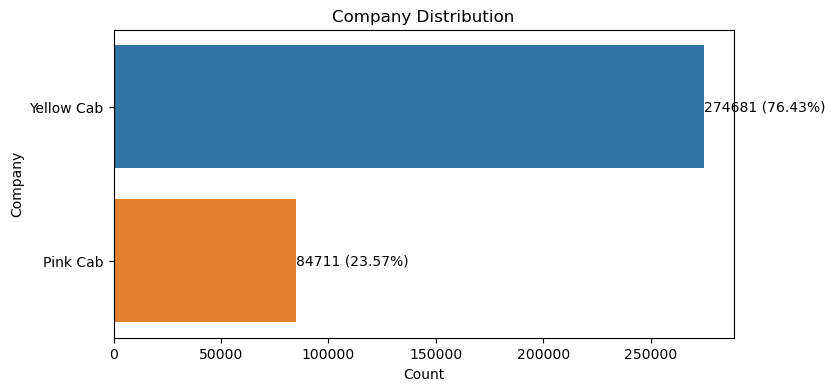

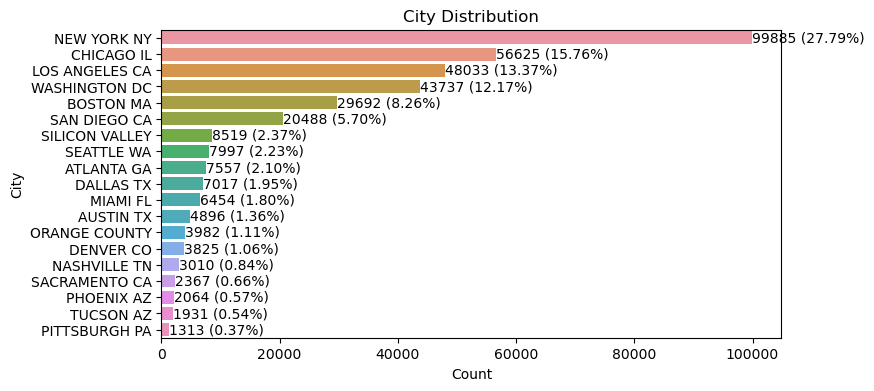

In [17]:
# Analysis of Categorical Variables

for col in cat_cols1:
    cat_summary(cab_data, col, plot=True)

- Yellow Cab company dominates with 76.43% of the operations, while Pink Cab company accounts for 23.57%. It's clear that Yellow Cab has a significant advantage in this regard.

- When we examine the cities, we can see that NEW YORK, CHICAGO, and LOS ANGELES lead in terms of transactions.

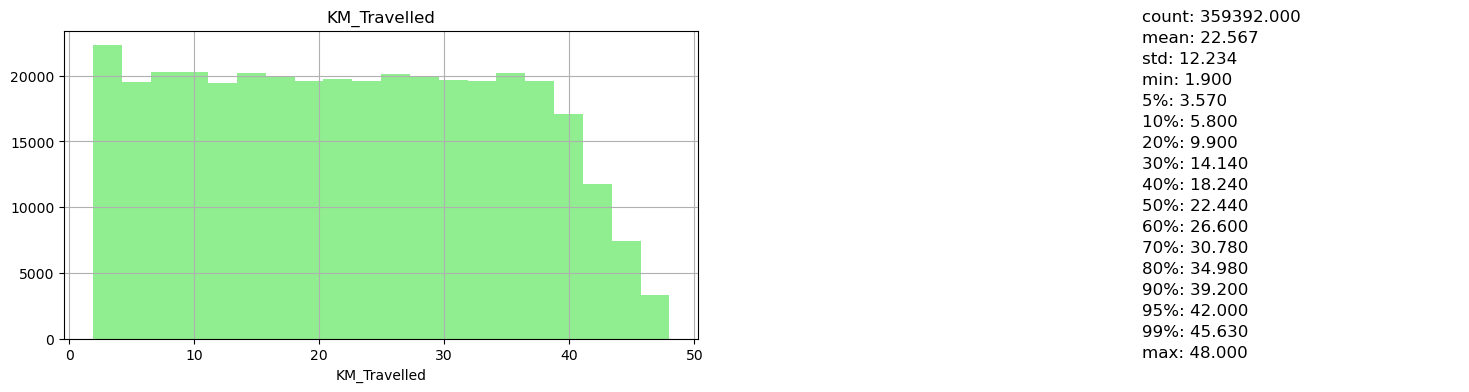

################################################################


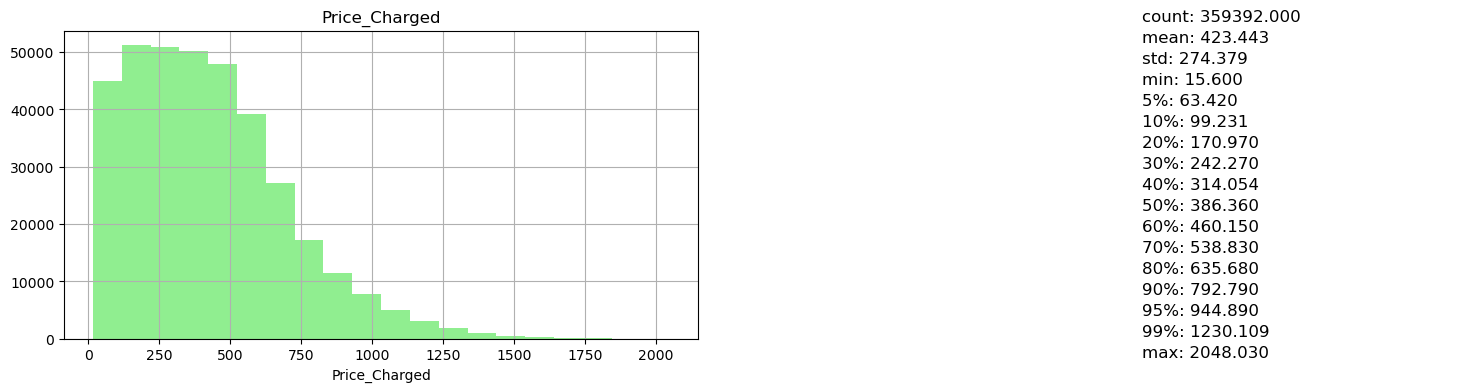

################################################################


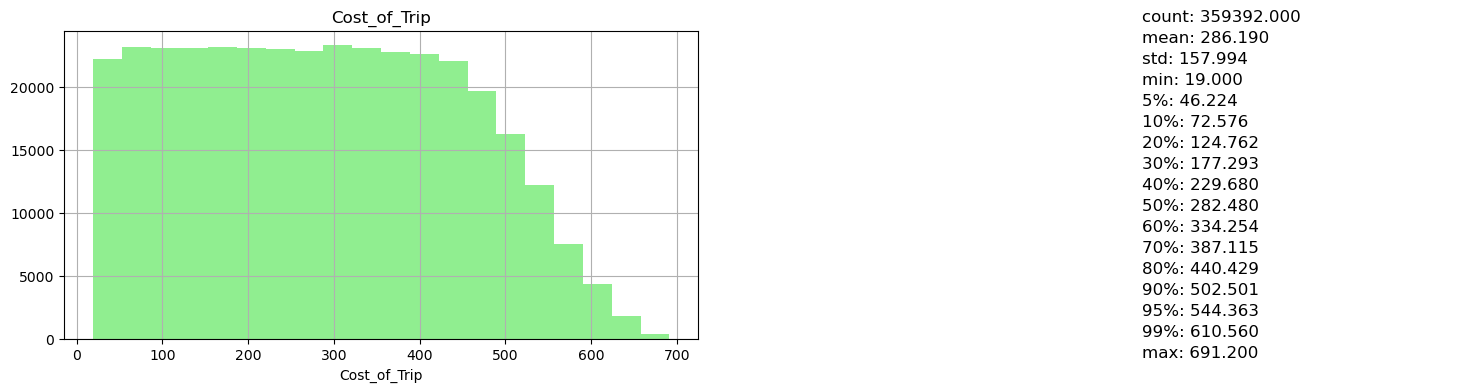

################################################################


In [18]:
# Analysis of Numerical Variables

for col in num_cols1:
    num_summary(cab_data, col, plot=True) 

- When we examine the graph, we observe that the closest distance traveled is 1.9 km, while the farthest distance is 48 km. 

- Additionally, when we look at the Price_Charged variable, we notice that there is no normal distribution. The reason for this could be outliers, as we can see that the maximum value is approximately 2048, while the median value is around 386.

- The lowest trip cost is observed to be 19 dollars, while the highest is approximately 691 dollars.

In [19]:
# Outlier Analysis

for col in num_cols1:
    print(col, check_outlier(cab_data, col))

KM_Travelled False
Price_Charged True
Cost_of_Trip False


- In this dataset, it can be observed that there are outlier values in the "Price_Charged" data. But I preferred not to perform any operation on the outliers. 

<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>customer_data DataFrame Analysis</h3>
</div>

In [20]:
check_df(customer_data)

##################### Shape #####################
Rows: 49171
Columns: 4

##################### Types #####################
Customer ID            int64
Gender                object
Age                    int64
Income (USD/Month)     int64
dtype: object

##################### Head #####################
   Customer ID Gender  Age  Income (USD/Month)
0        29290   Male   28               10813
1        27703   Male   27                9237
2        28712   Male   53               11242
3        28020   Male   23               23327
4        27182   Male   33                8536

##################### Tail #####################
       Customer ID  Gender  Age  Income (USD/Month)
49166        12490    Male   33               18713
49167        14971    Male   30               15346
49168        41414    Male   38                3960
49169        41677    Male   23               19454
49170        39761  Female   32               10128

##################### NA #####################
Cust

- **The average age of customers is approximately 35 years.**
- **The average monthly income of customers is around 15,000 dollars.**
- **No missing values are present in the dataset.**
- **We need to change the type of "Customer ID" columns.**

In [21]:
check_duplicates(customer_data)

No duplicate rows found in the DataFrame.


In [22]:
# Changing the type of Customer ID datatype 

customer_data['Customer ID'] = customer_data['Customer ID'].astype(str)

In [23]:
customer_data.columns = customer_data.columns.str.replace(' ', '_')

In [24]:
customer_data.head()

,Customer_ID,Gender,Age,Income_(USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [25]:
# Capturing numerical and Categorical variables

cat_cols2, num_cols2, cat_but_car2 = grab_col_names(customer_data)

Observations: 49171
Variables: 4
cat_cols: 1
num_cols: 2
cat_but_car: 1
num_but_cat: 0


In [26]:
cat_cols2, num_cols2, cat_but_car2

(['Gender'], ['Age', 'Income_(USD/Month)'], ['Customer_ID'])

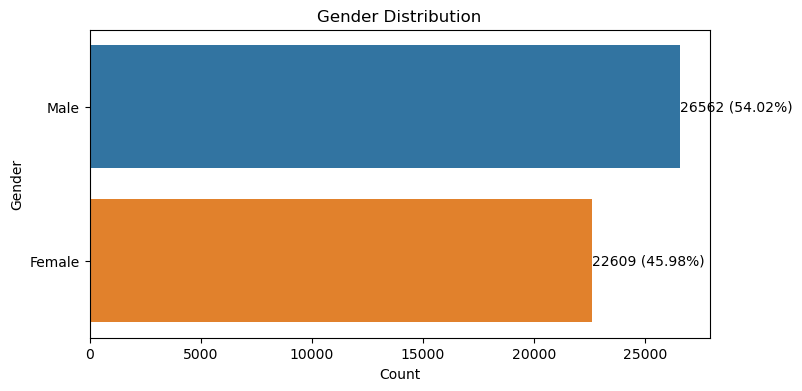

In [27]:
# Analysis of Categorical Variables

for col in cat_cols2:
    cat_summary(customer_data, col, plot=True)

When we examine the gender distribution of customers, it is observed that male customers make up approximately 54%, while female customers account for around 46%

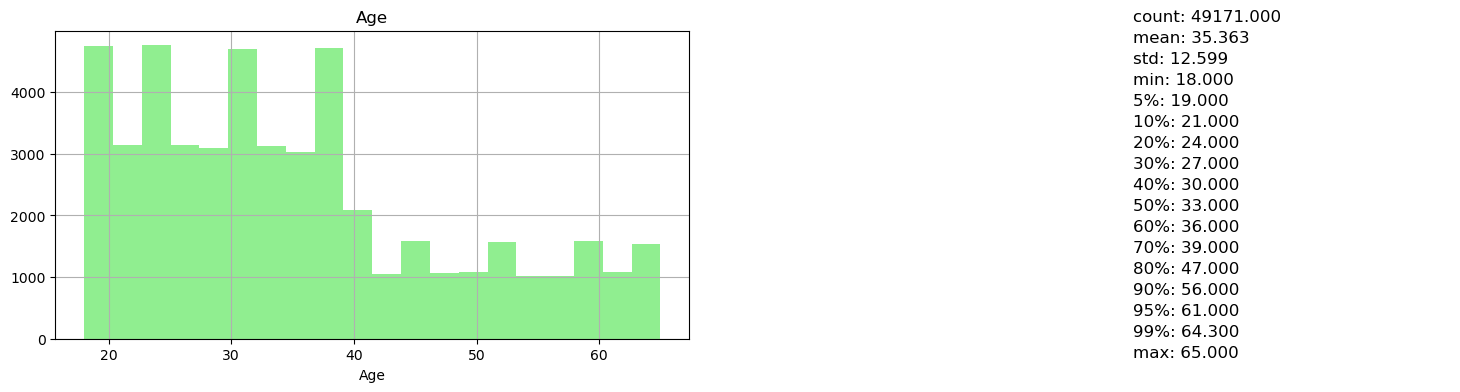

################################################################


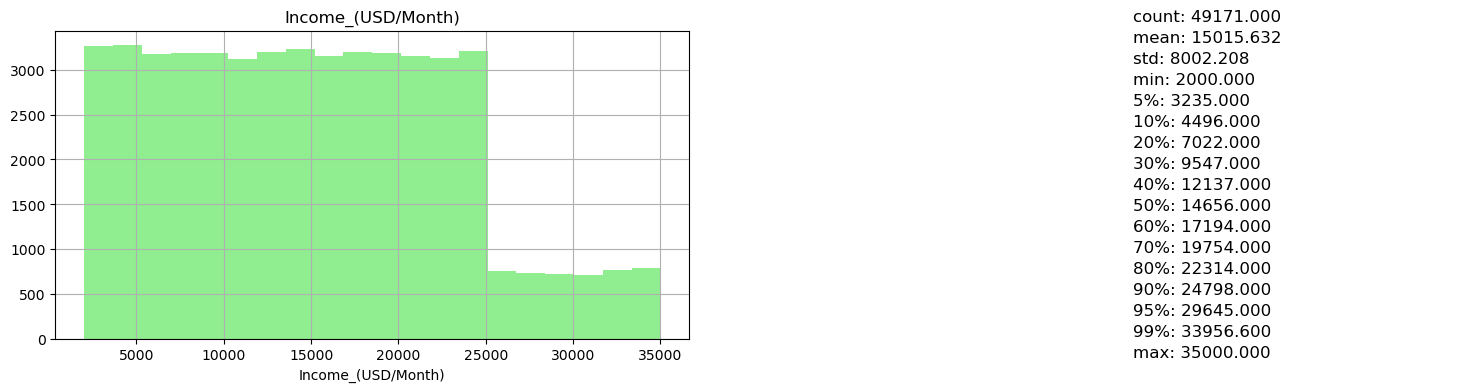

################################################################


In [28]:
# Analysis of Numerical Variables

for col in num_cols2:
    num_summary(customer_data, col, plot=True)

- Over 70% of customers are under the age of 40.
- Approximately 10% of customers have a monthly income exceeding $25,000.

In [29]:
# Outlier Analysis

for col in num_cols2:
    print(col, check_outlier(customer_data, col))

Age False
Income_(USD/Month) False


- There are no outliers in this dataset.

<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>transaction_data DataFrame Analysis</h3>
</div>

In [30]:
check_df(transaction_data)

##################### Shape #####################
Rows: 440098
Columns: 3

##################### Types #####################
Transaction ID     int64
Customer ID        int64
Payment_Mode      object
dtype: object

##################### Head #####################
   Transaction ID  Customer ID Payment_Mode
0        10000011        29290         Card
1        10000012        27703         Card
2        10000013        28712         Cash
3        10000014        28020         Cash
4        10000015        27182         Card

##################### Tail #####################
        Transaction ID  Customer ID Payment_Mode
440093        10440104        53286         Cash
440094        10440105        52265         Cash
440095        10440106        52175         Card
440096        10440107        52917         Card
440097        10440108        51587         Card

##################### NA #####################
Transaction ID    0
Customer ID       0
Payment_Mode      0
dtype: int64

######

- **No missing values are present in the dataset.**
- **We need to change the type of "Transaction ID" and "Customer ID" columns.**

In [31]:
check_duplicates(transaction_data)

No duplicate rows found in the DataFrame.


In [32]:
transaction_data[['Transaction ID', 'Customer ID']] = transaction_data[['Transaction ID', 'Customer ID']].astype(str)

In [33]:
transaction_data.columns = transaction_data.columns.str.replace(' ', '_')

In [34]:
# Capturing numerical and Categorical variables

cat_cols3, num_cols3, cat_but_car3 = grab_col_names(transaction_data)

Observations: 440098
Variables: 3
cat_cols: 1
num_cols: 0
cat_but_car: 2
num_but_cat: 0


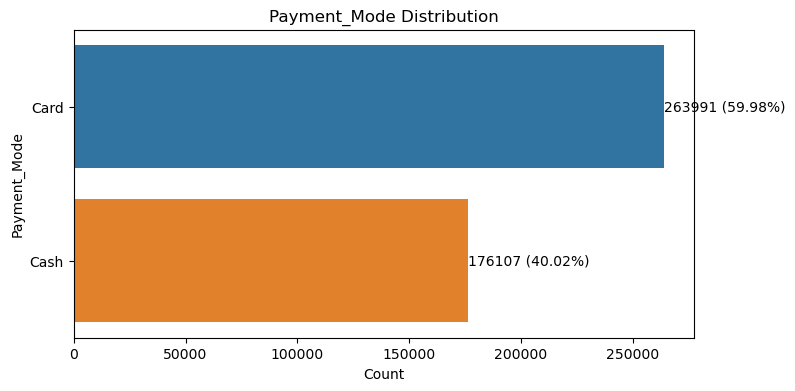

In [35]:
# Analysis of Categorical Variables

for col in cat_cols3:
    cat_summary(transaction_data, col, plot=True)

- When we examine the graph, we observe that nearly 60% of the transactions have been made using a card.

<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>city_data DataFrame Analysis</h3>
</div>

In [36]:
check_df(city_data)

##################### Shape #####################
Rows: 20
Columns: 3

##################### Types #####################
City          object
Population    object
Users         object
dtype: object

##################### Head #####################
             City   Population      Users
0     NEW YORK NY   8,405,837    302,149 
1      CHICAGO IL   1,955,130    164,468 
2  LOS ANGELES CA   1,595,037    144,132 
3        MIAMI FL   1,339,155     17,675 
4  SILICON VALLEY   1,177,609     27,247 

##################### Tail #####################
             City Population      Users
15  SACRAMENTO CA   545,776      7,044 
16  PITTSBURGH PA   542,085      3,643 
17  WASHINGTON DC   418,859    127,001 
18   NASHVILLE TN   327,225      9,270 
19      BOSTON MA   248,968     80,021 

##################### NA #####################
City          0
Population    0
Users         0
dtype: int64

##################### Quantiles #####################
           count unique          top freq
City

- **We need to change the type of Populations and Users Cols in city_data.**

In [37]:
city_data['Population'] = city_data['Population'].str.replace(',', '').astype(float)
city_data['Users'] = city_data['Users'].str.replace(',', '').astype(float)

In [38]:
city_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        20 non-null     object 
 1   Population  20 non-null     float64
 2   Users       20 non-null     float64
dtypes: float64(2), object(1)
memory usage: 608.0+ bytes


In [39]:
check_duplicates(city_data)

No duplicate rows found in the DataFrame.


In [40]:
# Capturing numerical and Categorical variables

cat_cols4, num_cols4, cat_but_car4 = grab_col_names(city_data)

Observations: 20
Variables: 3
cat_cols: 0
num_cols: 2
cat_but_car: 1
num_but_cat: 0


In [41]:
num_cols4, cat_but_car4 

(['Population', 'Users'], ['City'])

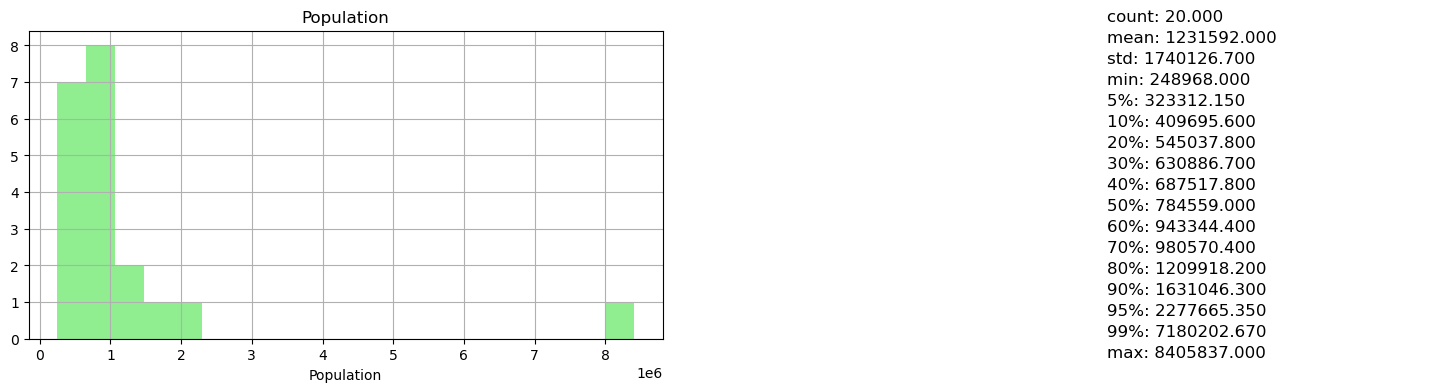

################################################################


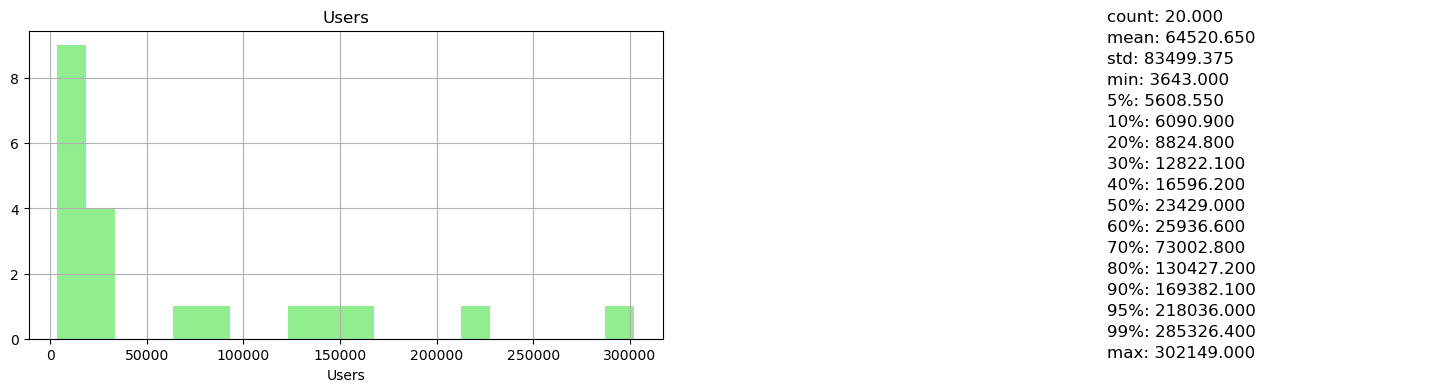

################################################################


In [42]:
# Analysis of Numerical Variables

for col in num_cols4:
    num_summary(city_data, col, plot=True) 

- When examining the graph, it is evident that the city with the lowest population has approximately 250,000, while the city with the largest population has around 8.5 million.

- The number of users among the cities where taxi companies operate ranges from a minimum of 3,643 to a maximum of 302,149.

In [43]:
# Outlier Analysis

for col in num_cols4:
    print(col, check_outlier(city_data, col))

Population True
Users False


- In this dataset, it can be observed that there are outlier values in the "Population" data. But I preferred not to perform any operation on the outliers. 

# 3. Merging the Whole Dataset

In [44]:
# Merging cab_data and transaction_data datasets

merged_cab_transaction = pd.merge(cab_data, transaction_data, on="Transaction_ID")

In [45]:
merged_cab_transaction.head(3)

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Customer_ID,Payment_Mode
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.450,370.950,313.635,29290,Card
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.620,358.520,334.854,27703,Card
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.040,125.200,97.632,28712,Cash


In [46]:
# Merging customer_data and merged_cab_transaction datasets

merged_customer_cab_transaction = pd.merge(merged_cab_transaction, customer_data, on="Customer_ID")


In [47]:
merged_customer_cab_transaction.head(3)

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Customer_ID,Payment_Mode,Gender,Age,Income_(USD/Month)
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.450,370.950,313.635,29290,Card,Male,28,10813
1,10351127,2018-07-21,Yellow Cab,ATLANTA GA,26.190,598.700,317.423,29290,Cash,Male,28,10813
2,10412921,2018-11-23,Yellow Cab,ATLANTA GA,42.550,792.050,597.402,29290,Card,Male,28,10813


In [48]:
# Merging cab_data and city_data datasets

df = pd.merge(merged_customer_cab_transaction, city_data, on="City")

In [49]:
df.head(3)

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Customer_ID,Payment_Mode,Gender,Age,Income_(USD/Month),Population,Users
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.450,370.950,313.635,29290,Card,Male,28,10813,814885.000,24701.000
1,10351127,2018-07-21,Yellow Cab,ATLANTA GA,26.190,598.700,317.423,29290,Cash,Male,28,10813,814885.000,24701.000
2,10412921,2018-11-23,Yellow Cab,ATLANTA GA,42.550,792.050,597.402,29290,Card,Male,28,10813,814885.000,24701.000


In [50]:
df.shape

(359392, 14)

### Correlation Analysis

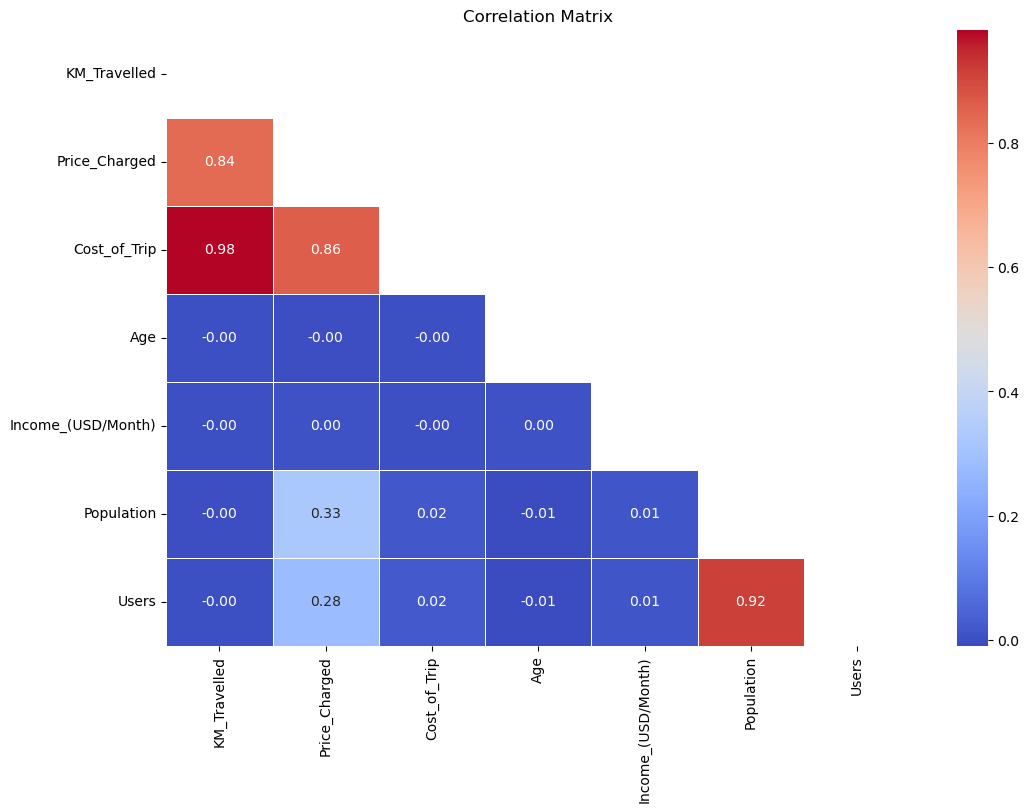

In [51]:
# Selecting only numeric columns
numeric_columns = df.select_dtypes(include=['number'])

# Calculating the correlation matrix
correlation_matrix = numeric_columns.corr()

# Creating a lower-triangle mask to hide the upper part of the heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, mask=mask)
plt.title("Correlation Matrix")
plt.show()

- **As observed, there is a high correlation between <span style="background-color: gray; padding: 2px 4px; color: white;">Population</span> and <span style="background-color: gray; padding: 2px 4px; color: white;">Users</span>.**
- **Additionally, there is a high correlation between <span style="background-color: gray; padding: 2px 4px; color: white;">Price_Charged</span>, <span style="background-color: gray; padding: 2px 4px; color: white;">Cost_of_Trip</span>, and <span style="background-color: gray; padding: 2px 4px; color: white;">KM_Travelled</span>.**

# 4. Comprehensive Analysis of the Whole Dataset

In [52]:
df_new=df.copy()

In [53]:
# Calculating profit for each trip

df_new['Profit'] = df_new['Price_Charged'] - df_new['Cost_of_Trip']

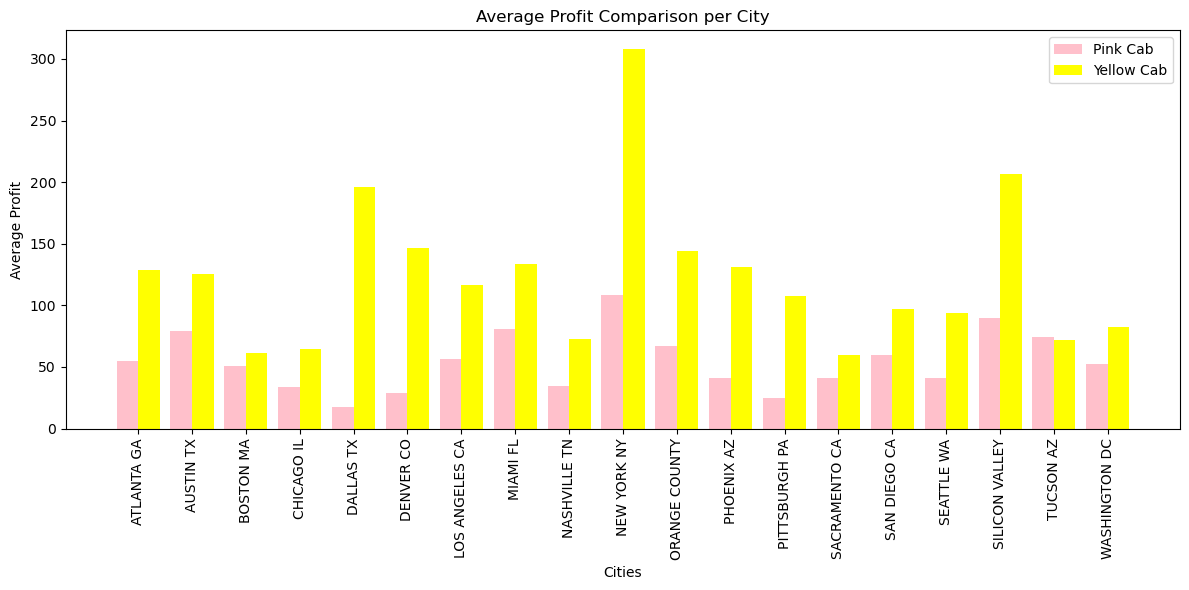

In [54]:
# Calculating average profit per city for Pink Cab and Yellow Cab
city_profit = df_new.groupby(['City', 'Company']).agg({'Profit': 'mean'}).unstack()

# Generating the bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = np.arange(len(city_profit.index))

plt.bar(index, city_profit['Profit']['Pink Cab'], bar_width, label='Pink Cab', color='pink')
plt.bar(index + bar_width, city_profit['Profit']['Yellow Cab'], bar_width, label='Yellow Cab', color='yellow')

plt.xticks(index + bar_width / 2, city_profit.index, rotation=90)
plt.xlabel('Cities')
plt.ylabel('Average Profit')
plt.title('Average Profit Comparison per City')
plt.legend()

plt.tight_layout()
plt.show()

- In all cities except Tucson, AZ, the average profit of Yellow Cab is higher than that of Pink Cab.

<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>Payment Mode Comparison by Company</h3>
</div>

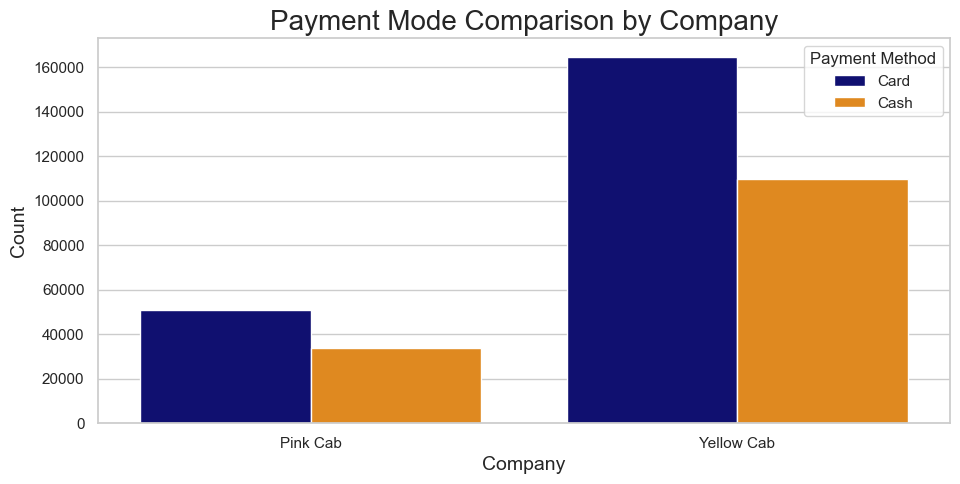

In [55]:
# Creating the graph using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(11, 5))  
sns.countplot(x="Company", hue="Payment_Mode", data=df_new, palette={"Card": "navy", "Cash": "darkorange"})

plt.title('Payment Mode Comparison by Company', fontsize=20)  
plt.xlabel('Company', fontsize=14)  
plt.ylabel('Count', fontsize=14)  

plt.legend(title="Payment Method")  

plt.show()

- **As we can see that users prefer to pay with a card more as compared to cash.**

### <span style="color:red; font-weight:bold;">Hypothesis 1:</span> <span style="color:darkgreen; font-weight:bold;">Is there a difference in profit based on Payment Mode?</span>

- H0 : There is no difference in profit based on payment mode.
- H1 : There is a difference in profit based on payment mode. 

### Assumptions checking for hypotheses:
- Functions below check the normality assumption of the data using the Shapiro-Wilk test and the homogeneity of variance using the Levene test before hypothesis tests.
- If both assumptions (normality and homogeneity) are met, a parametric test is conducted.
- If the normal distribution assumption is not met, non-parametric tests are conducted.
- If normality is met but homogeneity is not, a parametric test can be conducted with the 'equal_var = False' argument

In [56]:
# Assumption of normality
##############################################
def shapiro_test(x, y):
    test_stat_x, pvalue_x = shapiro(x)
    test_stat_y, pvalue_y = shapiro(y)
    if pvalue_x < 0.05:
        print('Test Stat = %.4f, p-value = %.4f' % (test_stat_x, pvalue_x),
              'HO is rejected, the assumption of normal distribution is not satisfied')
    else:
        print('Test Stat = %.4f, p-value = %.4f' % (test_stat_x, pvalue_x),
              'HO is not rejected, the assumption of normal distribution is satisfied')
        

    
# Assumption of homogeneity of variance
##############################################
def levene_test(x, y):
    test_stat, pvalue = stats.levene(x, y)
    if pvalue < 0.05:
        print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue),
              'HO is rejected, the homogeneity of variance is not satisfied')
    else:
        print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue),
              'HO is not rejected, the homogeneity of variance is satisfied')

<h3 style="color:blue">Pink Cab</h3>

In [57]:
# Calculating the average profit for "Cash" transactions
cash_mean_profit_pink = df_new[(df_new.Company == 'Pink Cab') & (df_new.Payment_Mode == 'Cash')]['Profit'].mean()
print("Average Profit for Cash Transactions in Pink Cab: {:.3f}".format(cash_mean_profit_pink))

# Calculating the average profit for "Card" transactions
card_mean_profit_pink = df_new[(df_new.Company == 'Pink Cab') & (df_new.Payment_Mode == 'Card')]['Profit'].mean()
print("Average Profit for Card Transactions in Pink Cab: {:.3f}".format(card_mean_profit_pink))


Average Profit for Cash Transactions in Pink Cab: 62.565
Average Profit for Card Transactions in Pink Cab: 62.710


In [58]:
# Retrieving all "Profit" values for "Cash" transactions
cash_profits_pink = df_new[(df_new.Company == 'Pink Cab') & (df_new.Payment_Mode == 'Cash')]['Profit']

# Retrieving all "Profit" values for "Card" transactions
card_profits_pink = df_new[(df_new.Company == 'Pink Cab') & (df_new.Payment_Mode == 'Card')]['Profit']

In [59]:
# Assumption of normality:
# H0: The normal distribution assumption is satisfied.
# H1: The normal distribution assumption is not satisfied.
# p < 0.05 H0 is rejected, p > 0.05 H0 cannot be rejected.

# Assumptions
#############################################

# Normality
shapiro_test(cash_profits_pink, card_profits_pink)

# Homogeneity of variance
levene_test(cash_profits_pink, card_profits_pink)


Test Stat = 0.8616, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 0.7626, p-value = 0.3825 HO is not rejected, the homogeneity of variance is satisfied


Since the normal distribution assumption is not met, a non-parametric test, namely the Mann-Whitney U test, will be conducted.

In [60]:
# Mann-Whitney U test function
#############################################
def mann_whitney_u_test(group1, group2, alpha=0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    if p_value < alpha:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is rejected, there is a statistically significant difference between the groups')
    else:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is not rejected, there is not a statistically significant difference between the groups')
    

mann_whitney_u_test(cash_profits_pink, card_profits_pink)

Test Stat = 862495001.5000, p-value = 0.8917 HO is not rejected, there is not a statistically significant difference between the groups


<h3 style="color:blue">Yellow Cab</h3>

In [61]:
# Calculating the average profit for "Cash" transactions
cash_mean_profit_yellow = df_new[(df_new.Company == 'Yellow Cab') & (df_new.Payment_Mode == 'Cash')]['Profit'].mean()
print("Average Profit for Cash Transactions in Yellow Cab: {:.3f}".format(cash_mean_profit_yellow))

# Calculating the average profit for "Card" transactions
card_mean_profit_yellow = df_new[(df_new.Company == 'Yellow Cab') & (df_new.Payment_Mode == 'Card')]['Profit'].mean()
print("Average Profit for Card Transactions in Yellow Cab: {:.3f}".format(card_mean_profit_yellow))

Average Profit for Cash Transactions in Yellow Cab: 160.682
Average Profit for Card Transactions in Yellow Cab: 159.979


In [62]:
# Retrieving all "Profit" values for "Cash" transactions
cash_profits_yellow = df_new[(df_new.Company == 'Yellow Cab') & (df_new.Payment_Mode == 'Cash')]['Profit']

# Retrieving all "Profit" values for "Card" transactions
card_profits_yellow = df_new[(df_new.Company == 'Yellow Cab') & (df_new.Payment_Mode == 'Card')]['Profit']

In [63]:
# Assumptions
#############################################

# Normality
shapiro_test(cash_profits_yellow, card_profits_yellow)

# Homogeneity of variance
levene_test(cash_profits_yellow, card_profits_yellow)


Test Stat = 0.8364, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 2.9896, p-value = 0.0838 HO is not rejected, the homogeneity of variance is satisfied


Since the normal distribution assumption is not met, a non-parametric test, namely the Mann-Whitney U test, will be conducted.

In [64]:
# Mann-Whitney U test function
#############################################
def mann_whitney_u_test(group1, group2, alpha=0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    if p_value < alpha:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is rejected, there is a statistically significant difference between the groups')
    else:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is not rejected, there is not a statistically significant difference between the groups')
    

mann_whitney_u_test(cash_profits_yellow, card_profits_yellow)

Test Stat = 9056262516.0000, p-value = 0.9352 HO is not rejected, there is not a statistically significant difference between the groups


<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>Company and Gender</h3>
</div>

In [65]:
df_new.groupby(['Company','Gender'])['Customer_ID'].nunique()

Company     Gender
Pink Cab    Female    14819
            Male      17511
Yellow Cab  Female    18394
            Male      21502
Name: Customer_ID, dtype: int64

In [66]:
grouped = df_new.groupby(['Company','Gender'])['Customer_ID'].nunique().reset_index()

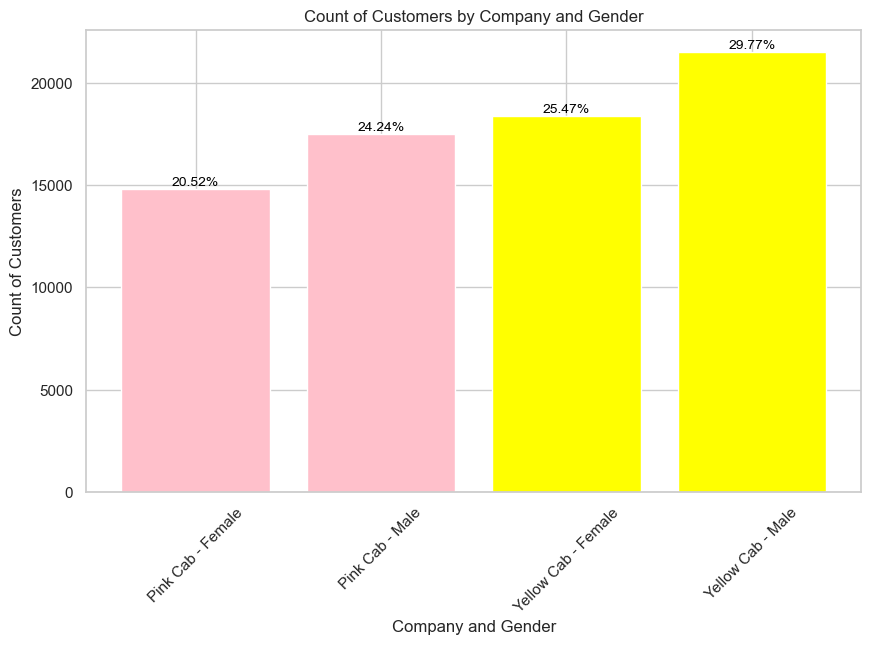

In [67]:
# Visualization
colors = {'Pink Cab': 'pink', 'Yellow Cab': 'yellow'}

plt.figure(figsize=(10, 6))
bars = []

for i, (company, gender, count) in grouped.iterrows():
    label = f'{company} - {gender}'
    total_customers = grouped['Customer_ID'].sum()
    percentage = (count / total_customers) * 100
    plt.bar(label, count, color=colors[company])
    plt.text(label, count, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Company and Gender')
plt.ylabel('Count of Customers')
plt.xticks(range(len(grouped)), ['{} - {}'.format(company, gender) for company, gender in zip(grouped['Company'], grouped['Gender'])], rotation=45)
plt.title('Count of Customers by Company and Gender')

plt.show()

- **When comparing the two cab companies, it can be observed that in both of them, there are more <span style="background-color: lightgrey;">Male</span> users.**
- **Additionally, it is evident that the <span style="background-color: lightgrey;">Yellow Cab</span> company has a larger user base.**


### <span style="color:red; font-weight:bold;">Hypothesis 2:</span> <span style="color:darkgreen; font-weight:bold;">Is there a significant difference in profit based on gender?</span>

- H0 : There is no difference in profit based on gender.
- H1 : There is a difference in profit based on gender.

<h3 style="color:blue">Pink Cab</h3>

In [68]:
# Calculating the number of female and male customers for the 'Pink Cab' company
pink_cab_female_customers = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Female')]['Customer_ID'].nunique()
pink_cab_male_customers = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Male')]['Customer_ID'].nunique()

print("Pink Cab Female Customers:", pink_cab_female_customers)
print("Pink Cab Male Customers:", pink_cab_male_customers)

# Calculating the total and mean profit for female and male customers of the 'Pink Cab' company
pink_cab_female_total_profit = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Female')]['Profit'].sum()
pink_cab_male_total_profit = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Male')]['Profit'].sum()

pink_cab_female_mean_profit = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Female')]['Profit'].mean()
pink_cab_male_mean_profit = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Male')]['Profit'].mean()

print("Pink Cab Female Total Profit:", pink_cab_female_total_profit)
print("Pink Cab Male Total Profit:", pink_cab_male_total_profit)
print("Pink Cab Female Mean Profit:", pink_cab_female_mean_profit)
print("Pink Cab Male Mean Profit:", pink_cab_male_mean_profit)

Pink Cab Female Customers: 14819
Pink Cab Male Customers: 17511
Pink Cab Female Total Profit: 2330532.691
Pink Cab Male Total Profit: 2976795.63
Pink Cab Female Mean Profit: 62.18070146744931
Pink Cab Male Mean Profit: 63.026309627151655


In [69]:
pink_female = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Female')]['Profit']
pink_male = df_new[(df_new['Company'] == 'Pink Cab') & (df_new['Gender'] == 'Male')]['Profit']

In [70]:
# Assumptions
#############################################

# Normality
shapiro_test(pink_female, pink_male)

# Homogeneity of variance
levene_test(pink_female, pink_male)


Test Stat = 0.8629, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 0.6671, p-value = 0.4141 HO is not rejected, the homogeneity of variance is satisfied


In [71]:
# Mann-Whitney U test function
#############################################
def mann_whitney_u_test(group1, group2, alpha=0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    if p_value < alpha:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is rejected, there is a statistically significant difference between the groups')
    else:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is not rejected, there is not a statistically significant difference between the groups')
    

mann_whitney_u_test(pink_female, pink_male)

Test Stat = 879754157.5000, p-value = 0.1298 HO is not rejected, there is not a statistically significant difference between the groups


<h3 style="color:blue">Yellow Cab</h3>

In [72]:
# Calculating the number of female and male customers for the 'Yellow Cab' company
yellow_cab_female_customers = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Female')]['Customer_ID'].nunique()
yellow_cab_male_customers = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Male')]['Customer_ID'].nunique()

print("Yellow Cab Female Customers:", yellow_cab_female_customers)
print("Yellow Cab Male Customers:", yellow_cab_male_customers)

# Calculating the total and mean profit for female and male customers of the 'Yellow Cab' company
yellow_cab_female_total_profit = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Female')]['Profit'].sum()
yellow_cab_male_total_profit = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Male')]['Profit'].sum()

yellow_cab_female_mean_profit = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Female')]['Profit'].mean()
yellow_cab_male_mean_profit = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Male')]['Profit'].mean()

print("Yellow Cab Female Total Profit:", yellow_cab_female_total_profit)
print("Yellow Cab Male Total Profit:", yellow_cab_male_total_profit)
print("Yellow Cab Female Mean Profit:", yellow_cab_female_mean_profit)
print("Yellow Cab Male Mean Profit:", yellow_cab_male_mean_profit)

Yellow Cab Female Customers: 18394
Yellow Cab Male Customers: 21502
Yellow Cab Female Total Profit: 18131417.6532
Yellow Cab Male Total Profit: 25888955.517599996
Yellow Cab Female Mean Profit: 156.30532459655174
Yellow Cab Male Mean Profit: 163.1509476093546


In [73]:
yellow_female = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Female')]['Profit']
yellow_male = df_new[(df_new['Company'] == 'Yellow Cab') & (df_new['Gender'] == 'Male')]['Profit']

In [74]:
# Assumptions
#############################################

# Normality
shapiro_test(yellow_female, yellow_male)

# Homogeneity of variance
levene_test(yellow_female, yellow_male)

Test Stat = 0.8349, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 104.1823, p-value = 0.0000 HO is rejected, the homogeneity of variance is not satisfied


In [75]:
# Mann-Whitney U test function
#############################################
def mann_whitney_u_test(group1, group2, alpha=0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    if p_value < alpha:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is rejected, there is a statistically significant difference between the groups')
    else:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is not rejected, there is not a statistically significant difference between the groups')
    

mann_whitney_u_test(yellow_female, yellow_male)

Test Stat = 9034571934.0000, p-value = 0.0000 HO is rejected, there is a statistically significant difference between the groups


<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>Income of Cab Customers</h3>
</div>

In [76]:
unique_customer_incomes = df_new.groupby('Customer_ID')['Income_(USD/Month)'].mean()

# Calculating the mean Income_(USD/Month) for customers of each taxi company
pink_cab_income_mean = df_new[df_new['Company'] == 'Pink Cab'].groupby('Customer_ID')['Income_(USD/Month)'].mean().mean()
yellow_cab_income_mean = df_new[df_new['Company'] == 'Yellow Cab'].groupby('Customer_ID')['Income_(USD/Month)'].mean().mean()

print("Pink Cab Income Mean:", pink_cab_income_mean)
print("Yellow Cab Income Mean:", yellow_cab_income_mean)

Pink Cab Income Mean: 15034.097618311165
Yellow Cab Income Mean: 14983.896831762582


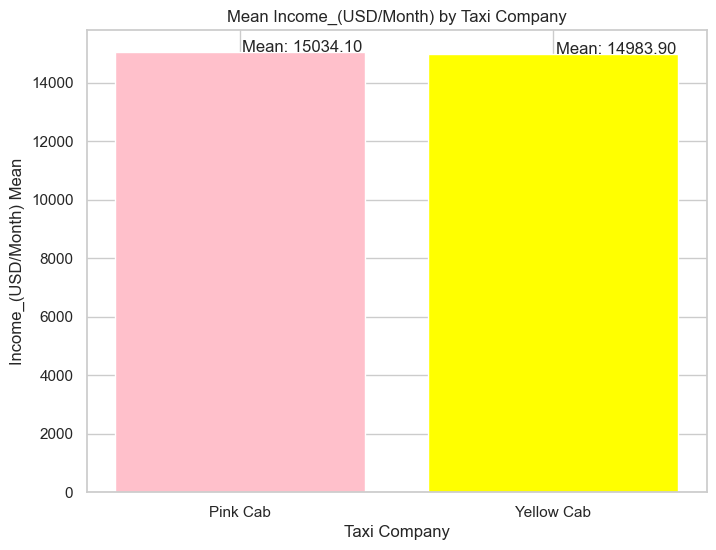

In [77]:
# Creating a bar chart comparing the mean Income_(USD/Month) for the two companies
companies = ['Pink Cab', 'Yellow Cab']
income_means = [pink_cab_income_mean, yellow_cab_income_mean]

plt.figure(figsize=(8, 6))
bars = plt.bar(companies, income_means, color=['pink', 'yellow'])
plt.xlabel('Taxi Company')
plt.ylabel('Income_(USD/Month) Mean')
plt.title('Mean Income_(USD/Month) by Taxi Company')

for bar, income_mean in zip(bars, income_means):
    plt.text(bar.get_x() + bar.get_width() - 0.2, bar.get_height(), f'Mean: {income_mean:.2f}', ha='center')

plt.show()

### <span style="color:red; font-weight:bold;">Hypothesis 3:</span> <span style="color:darkgreen; font-weight:bold;">Is there a significant difference in the incomes of Yellow Cab and Pink Cab customers?</span>

- H0 : There is no difference in the incomes of Yellow Cab and Pink Cab customers.
- H1 : There is a difference in the incomes of Yellow Cab and Pink Cab customers.

In [78]:
# Performing a hypothesis test
pink_cab_income = df_new[df_new['Company'] == 'Pink Cab'].groupby('Customer_ID')['Income_(USD/Month)'].mean()
yellow_cab_income = df_new[df_new['Company'] == 'Yellow Cab'].groupby('Customer_ID')['Income_(USD/Month)'].mean()

# Assumptions
#############################################

# Normality
shapiro_test(pink_cab_income, yellow_cab_income)

# Homogeneity of variance
levene_test(pink_cab_income, yellow_cab_income)

Test Stat = 0.9707, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 0.0395, p-value = 0.8424 HO is not rejected, the homogeneity of variance is satisfied


In [79]:
# Mann-Whitney U test function
#############################################
def mann_whitney_u_test(group1, group2, alpha=0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    if p_value < alpha:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is rejected, there is a statistically significant difference between the groups')
    else:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is not rejected, there is not a statistically significant difference between the groups')
    

mann_whitney_u_test(pink_cab_income, yellow_cab_income)

Test Stat = 647299744.0000, p-value = 0.3928 HO is not rejected, there is not a statistically significant difference between the groups


<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>Distribution of Cab Users Among Companies Over the Years</h3>
</div>

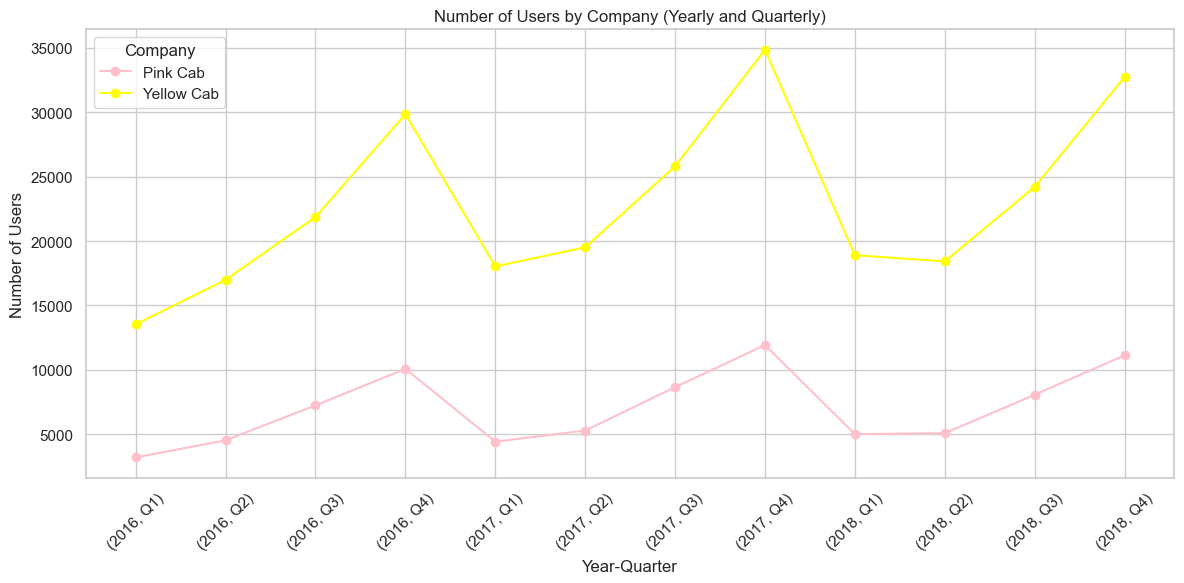

In [80]:
# Extracting year and quarter
df_new['Year'] = pd.to_datetime(df_new['Date_of_Travel']).dt.year
df_new['Quarter'] = pd.to_datetime(df_new['Date_of_Travel']).dt.quarter

# Grouping the data by year, quarter, and company
yearly_quarterly_data = df_new.groupby(['Year', 'Quarter', 'Company'])['Customer_ID'].count().unstack().fillna(0)

# Visualization
unique_years = sorted(df_new['Year'].unique())
colors = ['pink', 'yellow']

ax = yearly_quarterly_data.plot(kind='line', marker='o', figsize=(12, 6), color=colors)
plt.title('Number of Users by Company (Yearly and Quarterly)')
plt.xlabel('Year-Quarter')
plt.ylabel('Number of Users')
plt.legend(title='Company', loc='best')
plt.grid(True)

x_ticks = [f'({year}, Q{quarter})' for year in unique_years for quarter in range(1, 5)]
ax.set_xticks(range(len(x_ticks)))
ax.set_xticklabels(x_ticks, rotation=45)

plt.tight_layout()
plt.show()

- When the graph is examined, it can be seen that there is an increasing trend in customer cab usage demand from the first quarter to the fourth quarter in each of the years 2016, 2017, and 2018.

- The increasing trend in customer demand for cab usage from the first quarter to the fourth quarter in each of the years 2016, 2017, and 2018 may be attributed to various factors, including seasonal patterns, economic variables, special occasions, holidays, urban population growth, and the preference for cabs during adverse weather conditions.

<div style="text-align:center; background-color:navy; color:yellow; padding:10px;">
    <h3>The Impact of Loyal Customers and Champions on Profit in Yellow Cab and Pink Cab Companies</h3>
</div>

In [81]:
# Separating customers according to company
###########################################
pink_cab_customers = df_new[df_new['Company'] == 'Pink Cab']

yellow_cab_customers = df_new[df_new['Company'] == 'Yellow Cab']

In [82]:
df_new["Date_of_Travel"].max()

datetime.date(2018, 12, 31)

In [83]:
# The analysis date has been selected as two days after the date above.
today_date = dt.date(2019, 1, 2)

### RFM - Pink Cab

In [84]:
rfm_pink_cab = pink_cab_customers.groupby('Customer_ID').agg({'Date_of_Travel': lambda Date_of_Travel: (today_date - Date_of_Travel.max()).days,
                                     'Transaction_ID': lambda Transaction_ID: Transaction_ID.nunique(),
                                     'Price_Charged': lambda Price_Charged: Price_Charged.sum()})
rfm_pink_cab.columns = ['recency', 'frequency', 'monetary']
rfm_pink_cab.head()

,recency,frequency,monetary
Customer_ID,,,
1,388,4,2286.480
10,157,3,1001.490
100,439,4,1934.620
1000,72,6,2813.150
10001,33,1,28.650


In [85]:
rfm_pink_cab.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,32330.000,340.657,292.521,2.000,81.000,272.000,517.000,1096.000
frequency,32330.000,2.620,2.194,1.000,1.000,2.000,3.000,18.000
monetary,32330.000,814.360,762.878,15.600,294.532,543.455,1092.140,6568.900


In [86]:
# Calculating RFM Scores

rfm_pink_cab["recency_score"] = pd.qcut(rfm_pink_cab['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm_pink_cab["frequency_score"] = pd.qcut(rfm_pink_cab['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm_pink_cab["monetary_score"] = pd.qcut(rfm_pink_cab['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_pink_cab["RFM_SCORE"] = (rfm_pink_cab['recency_score'].astype(str) +
                    rfm_pink_cab['frequency_score'].astype(str))

In [87]:
# Creating & Analysing RFM Segments

seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

url = "https://cdn.enhencer.com/website-assets/images/blog/AdvantagesAndInefficaciesOfRFMSegmentation1.png"
Image(url=url, width=600, height=400)

In this section, the focus will be on the 'Champions' and 'Loyal Customers' segments as seen in the above chart.

In [88]:
rfm_pink_cab['segment'] = rfm_pink_cab['RFM_SCORE'].replace(seg_map, regex=True)

rfm_pink_cab.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer_ID,,,,,,,,
1,388,4,2286.480,2,4,5,24,at_risk
10,157,3,1001.490,4,4,4,44,loyal_customers
100,439,4,1934.620,2,4,5,24,at_risk
1000,72,6,2813.150,4,5,5,45,loyal_customers
10001,33,1,28.650,5,1,1,51,new_customers


In [89]:
# Number of 'Champions' and 'Loyal Customers' - Pink Cab

loyal_customers_champions_count = rfm_pink_cab[(rfm_pink_cab['segment'] == 'loyal_customers') | (rfm_pink_cab['segment'] == 'champions')].shape[0]

print("Loyal Customers + Champions Count:", loyal_customers_champions_count)


Loyal Customers + Champions Count: 10923


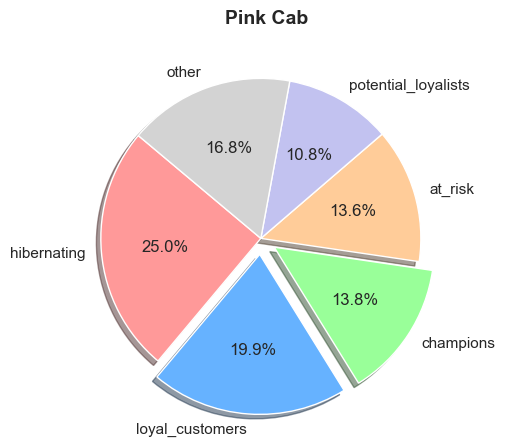

In [90]:
# Calculating segment proportions
segment_proportions = rfm_pink_cab['segment'].value_counts(normalize=True)

# Getting the top 5 segments by proportion
top_segments = segment_proportions.nlargest(5).index.tolist()

# Grouping other segments as "Other"
other_proportion = 1 - segment_proportions[top_segments].sum()
segment_proportions['other'] = other_proportion

# Defining colors
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#c2c2f0', 'lightgrey']

# Creating a pie chart
explode = [0.1 if segment in ['loyal_customers', 'champions'] else 0 for segment in segment_proportions.index]

# Filtering for the top segments and "other"
filtered_proportions = segment_proportions[top_segments + ['other']]
filtered_explode = [0.1 if segment in ['loyal_customers', 'champions'] else 0 for segment in filtered_proportions.index]

plt.pie(filtered_proportions, labels=filtered_proportions.index, autopct='%1.1f%%', shadow=True, colors=colors, startangle=140, explode=filtered_explode)
plt.axis('equal')


plt.title("Pink Cab", loc="center", y=1.08, fontsize=14, fontweight='bold')

plt.show()


### RFM - Yellow Cab

In [91]:
rfm_yellow_cab = yellow_cab_customers.groupby('Customer_ID').agg({'Date_of_Travel': lambda Date_of_Travel: (today_date - Date_of_Travel.max()).days,
                                     'Transaction_ID': lambda Transaction_ID: Transaction_ID.nunique(),
                                     'Price_Charged': lambda Price_Charged: Price_Charged.sum()})
rfm_yellow_cab.columns = ['recency', 'frequency', 'monetary']
rfm_yellow_cab.head()

,recency,frequency,monetary
Customer_ID,,,
1,17,25,15203.650
10,11,21,11906.240
100,14,35,21660.870
1000,39,27,14081.770
10000,365,2,963.070


In [92]:
rfm_yellow_cab.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,39896.000,262.796,279.443,2.000,40.000,133.000,425.000,1096.000
frequency,39896.000,6.885,8.183,1.000,1.000,3.000,10.000,47.000
monetary,39896.000,3154.549,4602.075,24.790,556.057,1260.965,3895.115,32351.360


In [93]:
# Calculating RFM Scores

rfm_yellow_cab["recency_score"] = pd.qcut(rfm_yellow_cab['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm_yellow_cab["frequency_score"] = pd.qcut(rfm_yellow_cab['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm_yellow_cab["monetary_score"] = pd.qcut(rfm_yellow_cab['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_yellow_cab["RFM_SCORE"] = (rfm_yellow_cab['recency_score'].astype(str) +
                    rfm_yellow_cab['frequency_score'].astype(str))

In [94]:
rfm_yellow_cab['segment'] = rfm_yellow_cab['RFM_SCORE'].replace(seg_map, regex=True)

rfm_yellow_cab.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer_ID,,,,,,,,
1,17,25,15203.650,5,5,5,55,champions
10,11,21,11906.240,5,5,5,55,champions
100,14,35,21660.870,5,5,5,55,champions
1000,39,27,14081.770,4,5,5,45,loyal_customers
10000,365,2,963.070,2,2,3,22,hibernating


In [95]:
# Number of 'Champions' and 'Loyal Customers' - Yellow Cab

loyal_customers_champions_count_y = rfm_yellow_cab[(rfm_yellow_cab['segment'] == 'loyal_customers') | (rfm_yellow_cab['segment'] == 'champions')].shape[0]

print("Loyal Customers + Champions Count:", loyal_customers_champions_count_y)


Loyal Customers + Champions Count: 14812


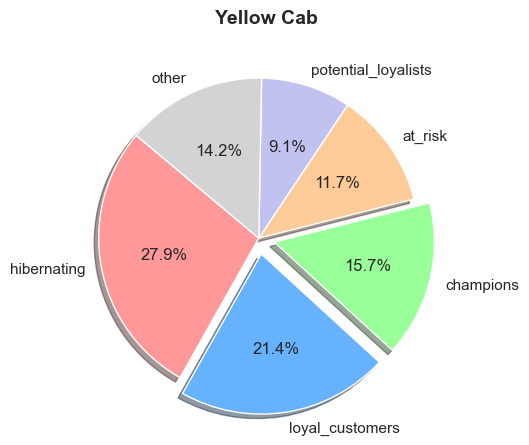

In [96]:
# Calculating segment proportions
segment_proportions_yellow = rfm_yellow_cab['segment'].value_counts(normalize=True)

# Getting the top 5 segments by proportion
top_segments_yellow = segment_proportions_yellow.nlargest(5).index.tolist()

# Grouping other segments as "other"
other_proportion_y = 1 - segment_proportions_yellow[top_segments_yellow].sum()
segment_proportions_yellow['other'] = other_proportion_y

# Defining colors
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#c2c2f0', 'lightgrey']

# Creating a pie chart
explode = [0.1 if segment in ['loyal_customers', 'champions'] else 0 for segment in segment_proportions_yellow.index]

# Filtering for the top segments and "other"
filtered_proportions_y = segment_proportions_yellow[top_segments_yellow + ['other']]
filtered_explode_y = [0.1 if segment in ['loyal_customers', 'champions'] else 0 for segment in filtered_proportions_y.index]

plt.pie(filtered_proportions_y, labels=filtered_proportions_y.index, autopct='%1.1f%%', shadow=True, colors=colors, startangle=140, explode=filtered_explode_y)
plt.axis('equal')


plt.title("Yellow Cab", loc="center", y=1.08, fontsize=14, fontweight='bold')

plt.show()

### <span style="color:red; font-weight:bold;">Hypothesis 4:</span> <span style="color:darkgreen; font-weight:bold;">Is there a significant difference in the contribution to Profit among loyal customers of the two companies?</span>

- H0 : There is no difference in the contribution to Profit among loyal customers of the two companies.
- H1 : There is a difference the contribution to Profit among loyal customers of the two companies. 

In [97]:
rfm_pink_cab['Profit'] = pink_cab_customers.groupby('Customer_ID')['Profit'].sum()
rfm_yellow_cab['Profit'] = yellow_cab_customers.groupby('Customer_ID')['Profit'].sum()

In [98]:
pink_cab_p = rfm_pink_cab[(rfm_pink_cab['segment'] == 'loyal_customers') | (rfm_pink_cab['segment'] == 'champions')]['Profit']
yellow_cab_y = rfm_yellow_cab[(rfm_yellow_cab['segment'] == 'loyal_customers') | (rfm_yellow_cab['segment'] == 'champions')]['Profit']

In [99]:
# Normality
shapiro_test(pink_cab_p, yellow_cab_y)

# Homogeneity of variance
levene_test(pink_cab_p, yellow_cab_y)


Test Stat = 0.9051, p-value = 0.0000 HO is rejected, the assumption of normal distribution is not satisfied
Test Stat = 3236.7792, p-value = 0.0000 HO is rejected, the homogeneity of variance is not satisfied


In [100]:
# Mann-Whitney U test function
#############################################
def mann_whitney_u_test(group1, group2, alpha=0.05):
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    if p_value < alpha:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is rejected, there is a statistically significant difference between the groups')
    else:
        print(f'Test Stat = {stat:.4f}, p-value = {p_value:.4f}', 'HO is not rejected, there is not a statistically significant difference between the groups')
    

mann_whitney_u_test(pink_cab_p, yellow_cab_y)

Test Stat = 13849021.5000, p-value = 0.0000 HO is rejected, there is a statistically significant difference between the groups


 The null hypothesis (H0) is rejected, and it can be stated that there is a difference between them.

- Based on the findings of these RFM analyses, specific marketing strategies and campaigns can be tailored to effectively target each customer segment, including customized communication, pricing strategies, loyalty programs, and improvements in the overall customer experience.

In [101]:

pink_cab_profit = pink_cab_p.sum()
yellow_cab_profit = yellow_cab_y.sum()

if pink_cab_profit > yellow_cab_profit:
    print("Pink Cab's loyal customers and champions generate more profit than Yellow Cab's.")
elif pink_cab_profit < yellow_cab_profit:
    print("Yellow Cab's loyal customers and champions generate more profit than Pink Cab's.")
else:
    print("Pink Cab's loyal customers and champions generate the same profit as Yellow Cab's.")


Yellow Cab's loyal customers and champions generate more profit than Pink Cab's.
